In [2]:
import os
import jsonpickle
import pandas as pd
import seaborn as sns
import multiprocessing as mp
import matplotlib.pyplot as plt
import py4a.api.accessor as accessor
from collections import Counter
from pkg_resources import parse_version

if not os.path.exists("output/figs"):
    os.makedirs("output/figs", exist_ok=True)

In [26]:
def get_api_stats(pkg: str, dynamic: bool) -> pd.DataFrame:
    stats = []
    vers = sorted(accessor.get_vers_with_apis(pkg, dynamic=dynamic), key=parse_version)
    with mp.Pool(min(len(vers), mp.cpu_count())) as pool:
        apis = pool.starmap(accessor.get_apis, [(pkg, v, dynamic) for v in vers])
    for ver, api in zip(vers, apis):
        stats.append({"pkg": pkg, "v": ver, "apis": sum(len(a.keys()) for a in api.values())})
    return pd.DataFrame(stats)
    
def get_evolution_stats(pkg: str, dynamic: bool) -> pd.DataFrame:
    stats, all_diffs = [], []
    vers = sorted(accessor.get_vers_with_apis(pkg, dynamic=dynamic), key=parse_version)
    base_dir = "output/dynamic/api-changes" if dynamic else "output/static/api-changes"
    for i in range(0, len(vers) - 1):
        v1, v2 = vers[i], vers[i + 1]
        with open(f"{base_dir}/{pkg}/{v1}-{v2}.json", "r") as f:
            diffs = jsonpickle.loads(f.read())
        v1s, v2s = parse_version(v1), parse_version(v2)
        t = "patch"
        if v1s.minor != v2s.minor:
            t = "minor"
        if v1s.major != v2s.major:
            t = "major"
        stats.append({
            "pkg": pkg,
            "v1": v1,
            "v2": v2,
            "t": t,
            "bc": len([d for d in diffs if d.is_breaking]),
            "nbc": len([d for d in diffs if not d.is_breaking]),
            "ubc": len([d for d in diffs if d.is_breaking and d.clients_used > 0]),
            "ibc": len([d for d in diffs if d.is_breaking and d.clients_impacted > 0])
        })
        all_diffs.extend(diffs)
    return pd.DataFrame(stats), all_diffs

def plot_api_evo(api_stats):
    fig, ax = plt.subplots(1, 1, figsize=(20, 6))
    ax.bar(x=range(0, len(api_stats)), height=api_stats.apis, tick_label=api_stats.v, label="APIs")
    ax.legend()
    fig.autofmt_xdate()
    return fig

def plot_breaking_change(evo_stats):
    fig, ax = plt.subplots(1, 1, figsize=(21, 3))
    tick_labels = [v1 + " - " + v2 for v1, v2 in zip(evo_stats.v1, evo_stats.v2)]
    ax.bar(
        x=[x - 0.45 for x in range(0, len(evo_stats))],
        height=evo_stats.nbc,
        width=0.3,
        align="edge",
        label="Non-Breaking Changes"
    )
    ax.bar(
        x=[x - 0.15 for x in range(0, len(evo_stats))], 
        height=evo_stats.bc, 
        width=0.3,
        align="edge",
        tick_label=tick_labels, 
        label="Breaking Changes"
    )
    ax.bar(
        x=[x + 0.15 for x in range(0, len(evo_stats))],
        height=evo_stats.ubc,
        width=0.3,
        align="edge",
        label="Breaking Changes on Used APIs",
        color="C3",
    )
    """
    ax.bar(
        x=[x + 0.2 for x in range(0, len(evo_stats))],
        height=evo_stats.ibc,
        width=0.2,
        align="edge",
        label="Changes that Breaks Exising API Usages"
    )
    """
    ax.legend()
    ax.set_yscale("log")
    fig.autofmt_xdate()
    return fig

def analyze(pkg, dynamic):
    api_stats = get_api_stats(pkg, dynamic)
    evo_stats, all_diffs = get_evolution_stats(pkg, dynamic)
    app = "d" if dynamic else "s"
    fig = plot_api_evo(api_stats)
    fig.savefig(f"output/figs/api_evo_{pkg}_{app}.pdf", bbox_inches="tight")
    fig = plot_breaking_change(evo_stats)
    fig.savefig(f"output/figs/api_bc_{pkg}_{app}.pdf", bbox_inches="tight")

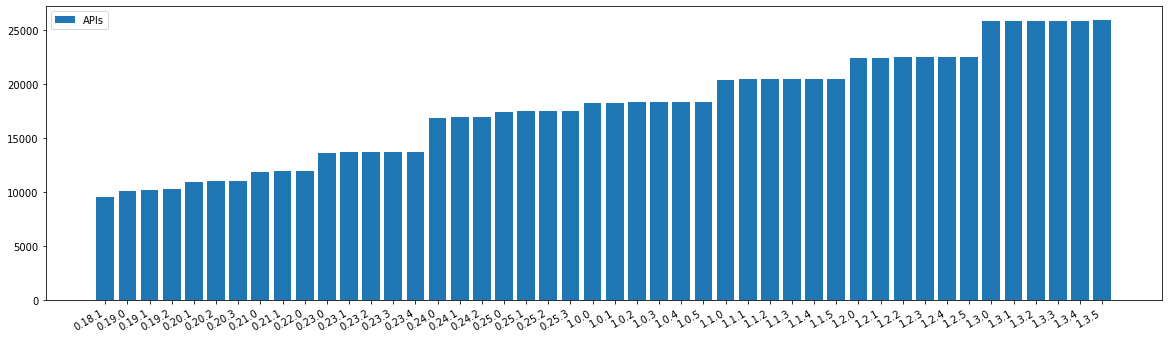

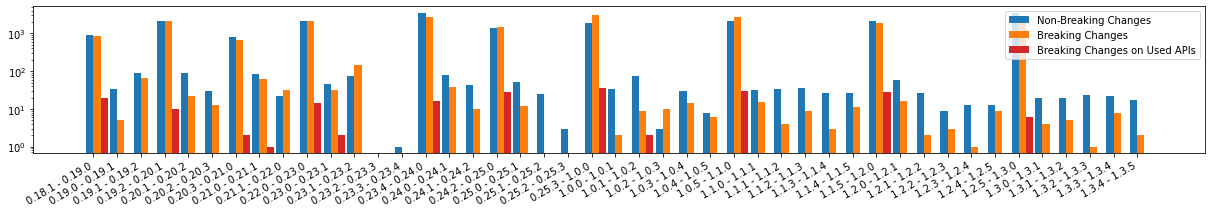

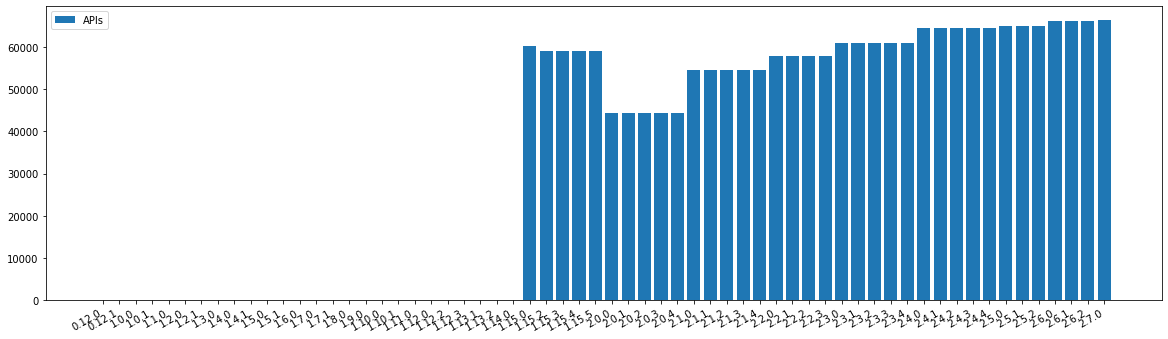

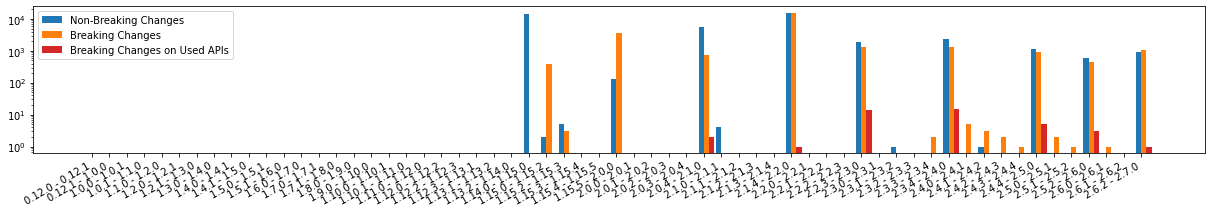

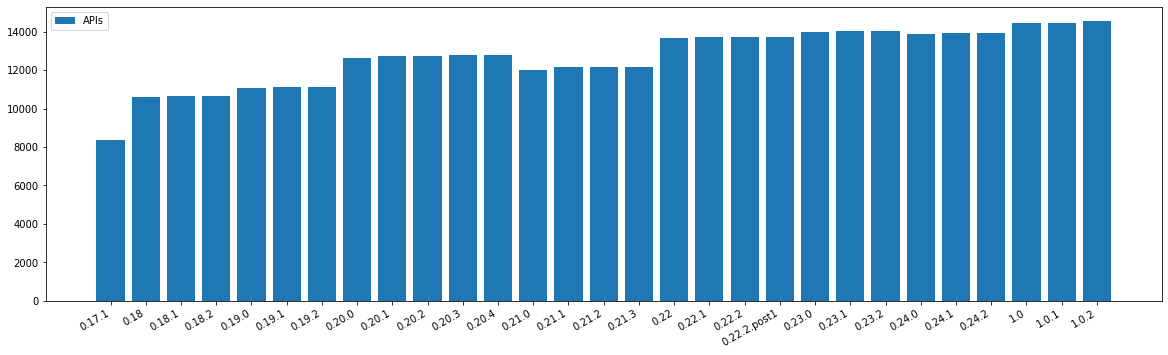

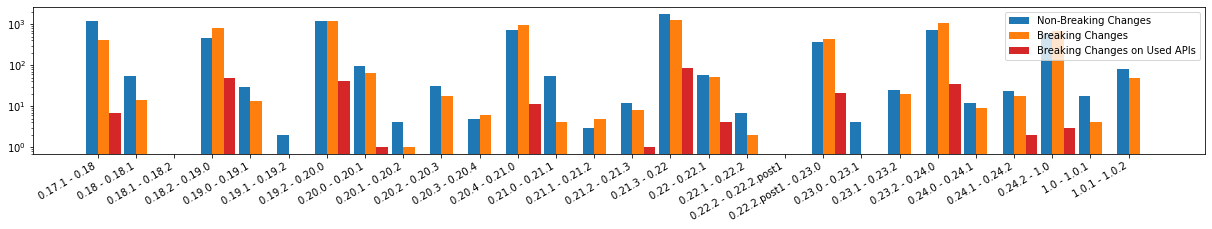

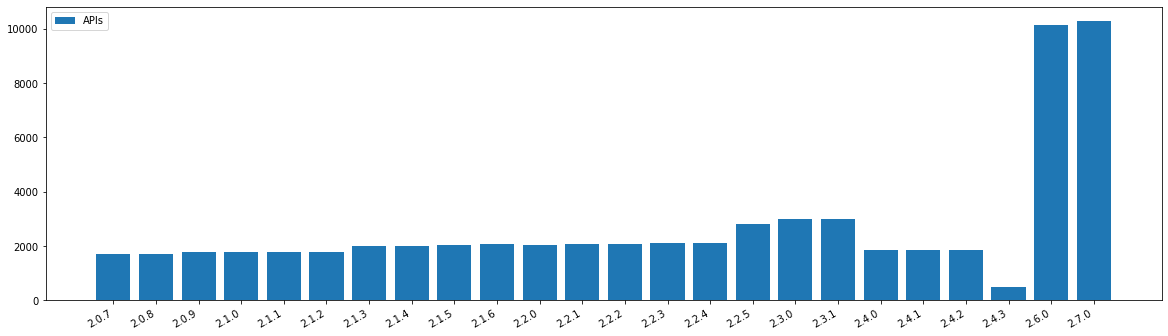

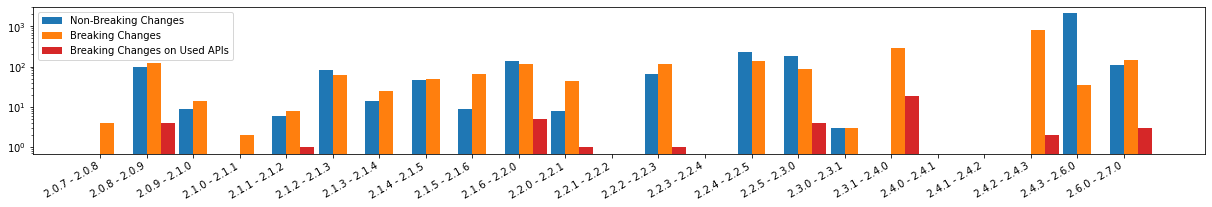

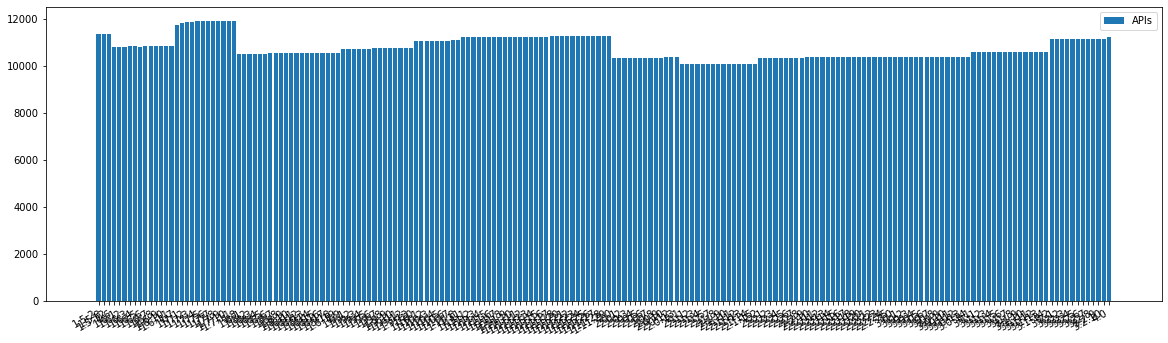

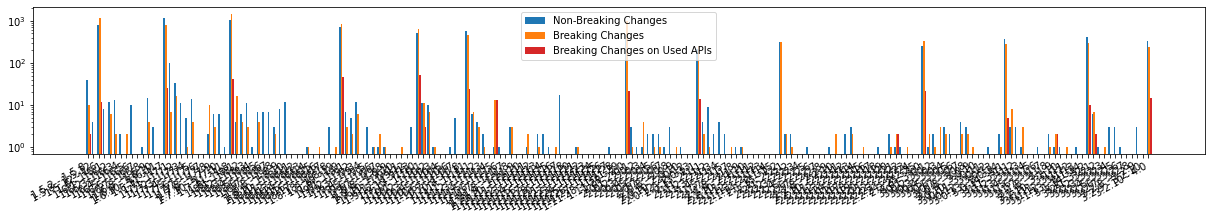

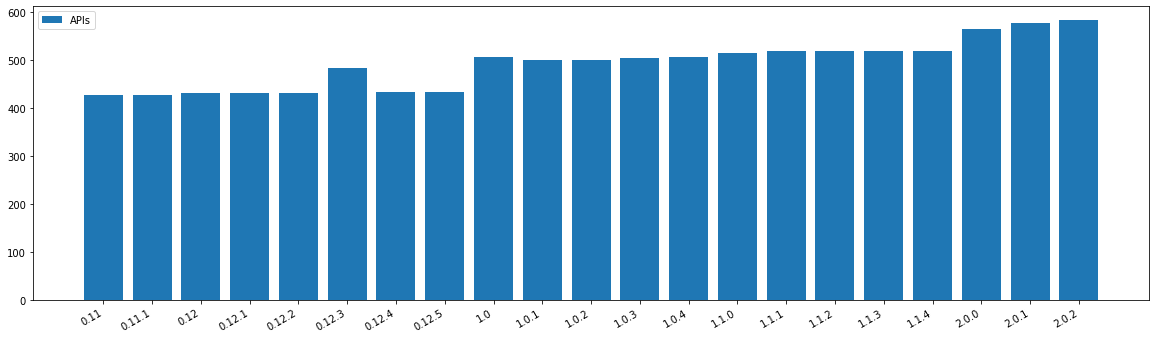

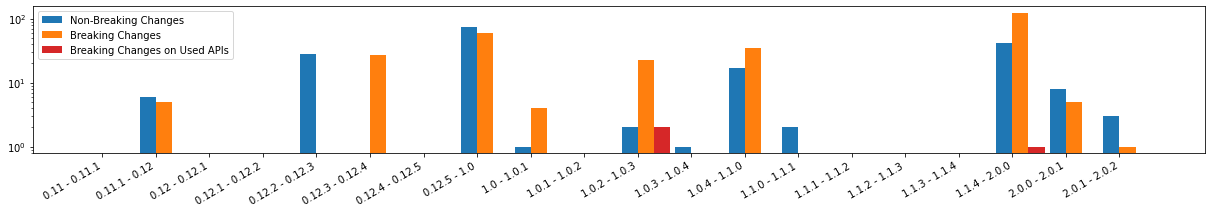

In [27]:
pkgs = ["pandas", "tensorflow", "scikit-learn", "keras", "django", "flask"]
for pkg in pkgs:
    analyze(pkg, False)
    # analyze(pkg, True)

In [23]:
all_diffs, diffs_used, diffs_with_impact = [], [], []
evo_stats_all = pd.DataFrame()
for pkg in pkgs:
    evo_stats, diffs = get_evolution_stats(pkg, dynamic=False)
    all_diffs.extend(diffs)
    evo_stats_all = pd.concat([evo_stats_all, evo_stats])
    diffs_used.extend([d for d in diffs if d.clients_used> 0 and d.is_breaking])
    diffs_with_impact.extend([d for d in diffs if d.clients_impacted > 0 and d.is_breaking])

cnt = Counter([d.diff_type.value for d in all_diffs])
cnt2 = Counter([d.diff_type.value for d in diffs_used])
cnt3 = Counter([d.diff_type.value for d in diffs_with_impact])
print(f"{'Breaking Change Type':32}: {'All':18} {'Used APIs':18} {'Impacted APIs':18}")
for t, val in sorted(cnt.items()):
    print(f"{t:32}: {val:7} ({val/sum(cnt.values())*100:4.2f}%)" + 
          (f"{cnt2[t]:7} ({cnt2[t]/sum(cnt2.values())*100:4.2f}%)" if t in cnt2 else "") +
          (f"{cnt3[t]:7} ({cnt3[t]/sum(cnt3.values())*100:4.2f}%)" if t in cnt2 else "")
         )

Breaking Change Type            : All                Used APIs          Impacted APIs     
Class Addition                  :   10277 (7.10%)
Class Removal                   :    6195 (4.28%)     92 (10.86%)     80 (28.37%)
Function Addition               :   50511 (34.88%)
Function Removal                :   26306 (18.16%)    169 (19.95%)    137 (48.58%)
Optional Parameter Addition     :    3732 (2.58%)    183 (21.61%)      0 (0.00%)
Optional Parameter Removal      :    1364 (0.94%)     55 (6.49%)      0 (0.00%)
Parameter Default Value Addition:     141 (0.10%)      4 (0.47%)      1 (0.35%)
Parameter Default Value Change  :     818 (0.56%)     54 (6.38%)      0 (0.00%)
Parameter Default Value Removal :     132 (0.09%)      7 (0.83%)      0 (0.00%)
Parameter Reordering            :    4122 (2.85%)    125 (14.76%)      0 (0.00%)
Required Parameter Addition     :    5234 (3.61%)     39 (4.60%)      0 (0.00%)
Required Parameter Removal      :    2125 (1.47%)     42 (4.96%)      1 (0.35%)
V

In [25]:
print(Counter(evo_stats_all.t))
major, minor, patch = evo_stats_all[evo_stats_all.t == "major"], evo_stats_all[evo_stats_all.t == "minor"], evo_stats_all[evo_stats_all.t == "patch"]
print(len(major), len(minor), len(patch))
print(len(major[major.bc == 0]), len(minor[minor.bc == 0]), len(patch[patch.bc == 0]))
print(len(major[major.ubc == 0]), len(minor[minor.ubc == 0]), len(patch[patch.ubc == 0]))
      

Counter({'patch': 305, 'minor': 57, 'major': 9})
9 57 305
1 15 161
3 21 286


In [24]:
evo_stats_all

,pkg,v1,v2,t,bc,nbc,ubc,ibc
0,pandas,0.18.1,0.19.0,minor,834,909,20,11
1,pandas,0.19.0,0.19.1,patch,5,34,0,0
2,pandas,0.19.1,0.19.2,patch,67,89,0,0
3,pandas,0.19.2,0.20.1,minor,2164,2183,10,7
4,pandas,0.20.1,0.20.2,patch,22,91,0,0
...,...,...,...,...,...,...,...,...
15,flask,1.1.2,1.1.3,patch,0,0,0,0
16,flask,1.1.3,1.1.4,patch,0,0,0,0
17,flask,1.1.4,2.0.0,major,122,42,1,1
18,flask,2.0.0,2.0.1,patch,5,8,0,0
